In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import sklearn
import scipy

import zipfile
import os
import gc
import warnings

pd.options.mode.chained_assignment = None  # default='warn'

## <center>Instacart Model Notebook</center>

A simple decision tree model to predict product reorders with the instacart dataset.

#### Making Changes to the Pipeline

- If making changes to the pipeline, change the all_data variable to FALSE (two cells below). 
- As there is over 3 million rows it takes way too long to use the whole dataset when testing.

#### Using F1-Score

- F1 score is a great metric of model performance, balancing precision and recall. This is great in our case as we have >80% of products that are not reordered and therefore raw accuracy would be misleading.

#### Memory Limits

- Be very conscious of memory limits. I delete dataframes as I go to stay within Colab/Kaggle limits.
- Given the size of the dataset these limits are reached very easily

In [2]:
%%time
# Data variables
PATH = os.getcwd() + '/instacart-market-basket-analysis/'
missing_value_formats = ["n.a.","?","NA","n/a", "na", "--","-"]

for file in os.listdir(PATH):
    dfname = file.split('.')[0].replace("__","_")
    globals()[dfname] = pd.read_csv(PATH + file, na_values = missing_value_formats)
    print(dfname)

aisles
departments
orders
order_products_prior
order_products_train
products
Wall time: 6.49 s


In [3]:
# add featuretools
import featuretools as ft
ft.__version__

C:\Users\yjhka\AppData\Local\Programs\Python\Python36\lib\site-packages\featuretools\__init__.py:60: FutureWarning: The next non-bugfix release of Featuretools will not support Python 3.6
  FutureWarning


'0.23.3'

In [4]:
order_products_prior = order_products_prior.reset_index()
order_products_prior.head(5)


,index,order_id,product_id,add_to_cart_order,reordered
0,0,2,33120,1,1
1,1,2,28985,2,1
2,2,2,9327,3,0
3,3,2,45918,4,1
4,4,2,30035,5,0


In [5]:

def load_entityset(orders, order_products_prior):
    # --- Write your code below ---
    # return the EntitySet object
    dataframes = {
        "orders": (orders, "order_id"),
        "order_products_prior": (order_products_prior, "index")
    }
    # relationships = [("orders", "order_id", "order_products_prior", "order_id"),
    #                  ("orders", "product_id", "products", "product_id")]
    relationships = [
        ("orders", "order_id", "order_products_prior", "order_id")]

    return ft.EntitySet("my entity set", dataframes, relationships)


In [6]:
es = load_entityset(orders, order_products_prior)
feature_matrix, feature_defs = ft.dfs(
    entityset=es, target_entity='order_products_prior')


In [7]:
df = feature_matrix.copy()
X_unselected = df.iloc[:, :]
y = df.iloc[:, 0]

# use featuretools selection
fm = ft.selection.remove_highly_null_features(df)
new_fm, new_features = ft.selection.remove_single_value_features(
    fm, features=feature_defs)

# using pearson correlation
cor = new_fm.corr()
cor

,order_id,product_id,add_to_cart_order,reordered,orders.user_id,orders.order_number,orders.order_dow,orders.order_hour_of_day,orders.days_since_prior_order,orders.COUNT(order_products_prior),...,orders.MIN(order_products_prior.product_id),orders.MIN(order_products_prior.reordered),orders.SKEW(order_products_prior.product_id),orders.SKEW(order_products_prior.reordered),orders.STD(order_products_prior.add_to_cart_order),orders.STD(order_products_prior.product_id),orders.STD(order_products_prior.reordered),orders.SUM(order_products_prior.add_to_cart_order),orders.SUM(order_products_prior.product_id),orders.SUM(order_products_prior.reordered)
order_id,1.000000,-0.000082,-0.000320,-0.000253,-0.000482,-0.000543,0.001205,0.000652,0.000727,-0.000478,...,0.000041,-0.000127,0.000429,0.000176,-0.000503,-0.001173,0.000067,-0.000600,-0.000397,-0.000487
product_id,-0.000082,1.000000,0.005529,0.003718,0.000080,-0.001925,-0.002350,0.000942,0.000800,0.007527,...,0.147987,-0.004353,-0.170966,-0.001824,0.007118,-0.003053,0.001732,0.003902,0.063675,0.005613
add_to_cart_order,-0.000320,0.005529,1.000000,-0.133024,0.000729,-0.004228,-0.009071,-0.014805,0.053951,0.669197,...,-0.278777,-0.145596,-0.015027,-0.078389,0.667050,0.050242,0.076188,0.617810,0.652430,0.492717
reordered,-0.000253,0.003718,-0.133024,1.000000,-0.000862,0.306840,-0.006949,-0.023300,-0.132814,0.005563,...,0.017048,0.313114,0.010860,-0.415955,0.006776,-0.015220,-0.049533,0.010165,0.005640,0.363676
orders.user_id,-0.000482,0.000080,0.000729,-0.000862,1.000000,-0.000768,-0.001630,-0.000415,0.000556,0.001090,...,0.000018,0.000849,-0.000043,0.002037,0.001118,0.000276,-0.000492,0.001314,0.001308,0.000786
orders.order_number,-0.000543,-0.001925,-0.004228,0.306840,-0.000768,1.000000,0.015209,-0.040049,-0.358422,-0.006318,...,0.009563,0.247028,0.011981,-0.336132,-0.007213,-0.005665,-0.086240,0.000119,-0.007949,0.293975
orders.order_dow,0.001205,-0.002350,-0.009071,-0.006949,-0.001630,0.015209,1.000000,0.012176,-0.030002,-0.013555,...,0.007706,0.000625,0.000990,0.013350,-0.013146,-0.000192,0.001529,-0.007071,-0.014727,-0.016550
orders.order_hour_of_day,0.000652,0.000942,-0.014805,-0.023300,-0.000415,-0.040049,0.012176,1.000000,0.003878,-0.022124,...,0.006318,-0.019445,-0.003843,0.028962,-0.022659,-0.001021,0.012812,-0.020719,-0.020940,-0.039294
orders.days_since_prior_order,0.000727,0.000800,0.053951,-0.132814,0.000556,-0.358422,-0.030002,0.003878,1.000000,0.080590,...,-0.039093,-0.122817,-0.006998,0.170526,0.081385,0.011673,0.106240,0.066299,0.079513,-0.072660
orders.COUNT(order_products_prior),-0.000478,0.007527,0.669197,0.005563,0.001090,-0.006318,-0.013555,-0.022124,0.080590,1.000000,...,-0.416585,-0.217568,-0.022684,-0.118333,1.000000,0.075320,0.114216,0.923211,0.974946,0.736282


In [8]:
cor = cor.sort_values(by='reordered', ascending=False).reset_index()



In [9]:
X_unselected


,order_id,product_id,add_to_cart_order,reordered,orders.user_id,orders.eval_set,orders.order_number,orders.order_dow,orders.order_hour_of_day,orders.days_since_prior_order,...,orders.MIN(order_products_prior.reordered),orders.SKEW(order_products_prior.add_to_cart_order),orders.SKEW(order_products_prior.product_id),orders.SKEW(order_products_prior.reordered),orders.STD(order_products_prior.add_to_cart_order),orders.STD(order_products_prior.product_id),orders.STD(order_products_prior.reordered),orders.SUM(order_products_prior.add_to_cart_order),orders.SUM(order_products_prior.product_id),orders.SUM(order_products_prior.reordered)
index,,,,,,,,,,,,,,,,,,,,,
0,2,33120,1,1,202279,prior,3,5,9,8.0,...,0,0.0,-0.588997,-0.857143,2.738613,15343.568140,0.500000,45,250807,6
1,2,28985,2,1,202279,prior,3,5,9,8.0,...,0,0.0,-0.588997,-0.857143,2.738613,15343.568140,0.500000,45,250807,6
2,2,9327,3,0,202279,prior,3,5,9,8.0,...,0,0.0,-0.588997,-0.857143,2.738613,15343.568140,0.500000,45,250807,6
3,2,45918,4,1,202279,prior,3,5,9,8.0,...,0,0.0,-0.588997,-0.857143,2.738613,15343.568140,0.500000,45,250807,6
4,2,30035,5,0,202279,prior,3,5,9,8.0,...,0,0.0,-0.588997,-0.857143,2.738613,15343.568140,0.500000,45,250807,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32434484,3421083,39678,6,1,25247,prior,24,2,6,21.0,...,0,0.0,0.444647,0.484123,3.027650,14733.844073,0.516398,55,213214,4
32434485,3421083,11352,7,0,25247,prior,24,2,6,21.0,...,0,0.0,0.444647,0.484123,3.027650,14733.844073,0.516398,55,213214,4
32434486,3421083,4600,8,0,25247,prior,24,2,6,21.0,...,0,0.0,0.444647,0.484123,3.027650,14733.844073,0.516398,55,213214,4


In [10]:
features = list(cor['index'][1:11])
features.append('reordered')
features.append('product_id')
features.append('order_id')

X = X_unselected[features]


In [13]:
del [orders, order_products_prior,
     departments, aisles, order_products_train, X_unselected]


In [11]:
X

,orders.MEAN(order_products_prior.reordered),orders.MAX(order_products_prior.reordered),orders.SUM(order_products_prior.reordered),orders.MIN(order_products_prior.reordered),orders.order_number,orders.MIN(order_products_prior.product_id),orders.SKEW(order_products_prior.product_id),orders.SUM(order_products_prior.add_to_cart_order),orders.STD(order_products_prior.add_to_cart_order),orders.SUM(order_products_prior.product_id),reordered,product_id,order_id
index,,,,,,,,,,,,,
0,0.666667,1,6,0,3,1819,-0.588997,45,2.738613,250807,1,33120,2
1,0.666667,1,6,0,3,1819,-0.588997,45,2.738613,250807,1,28985,2
2,0.666667,1,6,0,3,1819,-0.588997,45,2.738613,250807,0,9327,2
3,0.666667,1,6,0,3,1819,-0.588997,45,2.738613,250807,1,45918,2
4,0.666667,1,6,0,3,1819,-0.588997,45,2.738613,250807,0,30035,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32434484,0.400000,1,4,0,24,4600,0.444647,55,3.027650,213214,1,39678,3421083
32434485,0.400000,1,4,0,24,4600,0.444647,55,3.027650,213214,0,11352,3421083
32434486,0.400000,1,4,0,24,4600,0.444647,55,3.027650,213214,0,4600,3421083


In [12]:
train, valid = sklearn.model_selection.train_test_split(
    X, test_size=0.1)


# Building XGB Model

C:\Users\yjhka\AppData\Local\Programs\Python\Python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:04:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round", "parameters" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:04:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

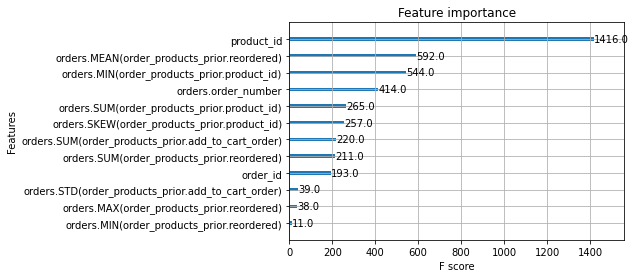

In [14]:
#creating data and labels
X_train, y_train = train.drop('reordered', axis=1), train['reordered']

#setting boosters parameters
parameters = {
    'eval_metric' : 'logloss',
    'max_depth' : 5,
    'colsample_bytree' : 0.4,
    'subsample' : 0.8
}

#instantiating the model
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', parameters=parameters, num_boost_round=10) #change to 10

#training model
model = xgb_clf.fit(X_train, y_train)
model.save_model("model.txt")

#feature importance plot
xgb.plot_importance(model)

# Making Validation Predictions

In [28]:
#creating data and labels
X_valid, y_valid = valid.drop('reordered', axis=1), train['reordered']

#predicting on the testing data
# y_pred = xgb_clf.predict(X_valid).astype('int')
# #setting a threshold.?


,orders.MEAN(order_products_prior.reordered),orders.MAX(order_products_prior.reordered),orders.SUM(order_products_prior.reordered),orders.MIN(order_products_prior.reordered),orders.order_number,orders.MIN(order_products_prior.product_id),orders.SKEW(order_products_prior.product_id),orders.SUM(order_products_prior.add_to_cart_order),orders.STD(order_products_prior.add_to_cart_order),orders.SUM(order_products_prior.product_id),reordered,product_id,order_id,prediction
index,,,,,,,,,,,,,,
20034303,0.642857,1,9,0,28,11408,0.236711,105,4.183300,418307,1,24946,2113066,1
31396548,0.642857,1,9,0,47,2716,-0.433719,105,4.183300,413972,1,18465,3311503,1
31105135,0.875000,1,7,0,15,12290,-1.395103,36,2.449490,284835,1,43014,3280911,1
29461178,0.750000,1,27,0,3,4421,0.015242,666,10.535654,847677,0,27683,3107185,1
25915325,0.400000,1,4,0,4,248,0.037097,55,3.027650,215674,1,31040,2732924,1


In [35]:
y_pred = (xgb_clf.predict_proba(X_valid)[:, 1] >= 0.50).astype('int')

# #saving the prediction as a new column in data_test
valid['prediction'] = y_pred
valid.head()


,orders.MEAN(order_products_prior.reordered),orders.MAX(order_products_prior.reordered),orders.SUM(order_products_prior.reordered),orders.MIN(order_products_prior.reordered),orders.order_number,orders.MIN(order_products_prior.product_id),orders.SKEW(order_products_prior.product_id),orders.SUM(order_products_prior.add_to_cart_order),orders.STD(order_products_prior.add_to_cart_order),orders.SUM(order_products_prior.product_id),reordered,product_id,order_id,prediction
index,,,,,,,,,,,,,,
20034303,0.642857,1,9,0,28,11408,0.236711,105,4.183300,418307,1,24946,2113066,1
31396548,0.642857,1,9,0,47,2716,-0.433719,105,4.183300,413972,1,18465,3311503,1
31105135,0.875000,1,7,0,15,12290,-1.395103,36,2.449490,284835,1,43014,3280911,1
29461178,0.750000,1,27,0,3,4421,0.015242,666,10.535654,847677,0,27683,3107185,1
25915325,0.400000,1,4,0,4,248,0.037097,55,3.027650,215674,1,31040,2732924,0


In [36]:
#valid f1_score
    print('F1 score: ', sklearn.metrics.f1_score(valid['reordered'], valid['prediction']))

F1 score:  0.8231092516302974


In [28]:
# Writing DF to disk for later eval
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    #writing validation file to disk
    valid.reset_index().to_csv("validation.csv")